# Fig: EPE/NELBO

In [1]:
# HIDE CODE


import os, sys
from IPython.display import display

# tmp & extras dir
git_dir = os.path.join(os.environ['HOME'], 'Dropbox/git')
extras_dir = os.path.join(git_dir, 'jb-MTMST/_extras')
fig_base_dir = os.path.join(git_dir, 'jb-MTMST/figs')
tmp_dir = os.path.join(git_dir, 'jb-MTMST/tmp')

# GitHub
sys.path.insert(0, os.path.join(git_dir, '_MTMST'))
from vae.train_vae import TrainerVAE, ConfigTrainVAE
from vae.vae2d import VAE, ConfigVAE
from figures.fighelper import *
from analysis.glm import *


# warnings, tqdm, & style
warnings.filterwarnings('ignore', category=DeprecationWarning)
from rich.jupyter import print
%matplotlib inline
set_style()

In [2]:
from analysis.linear import compute_dci

kws_fig = {
    'transparent': True,
    'bbox_inches': 'tight',
    'dpi': 300,
}
skip_fits = [
    'fixate1_nf-420_beta-0.001_(2023_05_16,00/03).npy',
    'fixate1_nf-420_beta-0.8_(2023_05_07,04:15).npy',
]
pal_model, pal_cat = get_palette()

## Load

In [3]:
path = pjoin(tmp_dir, 'trainer_analysis')

In [4]:
df_i_r2 = []
df_dci = collections.defaultdict(list)

for fit in tqdm(sorted(os.listdir(path))):
    if 'reservoir' in fit or fit in skip_fits:
        continue
    if fit in skip_fits:
        continue
    category, nf, beta, tag = extract_info(fit)    
    if beta in [0.001, 20.0]:
        continue

    # load
    everything = np.load(
        pjoin(path, fit),
        allow_pickle=True,
    ).item()
    
    # info
    df_dci['model'].append(tag)
    df_dci['category'].append(category)
    df_dci['beta'].append(beta)
    df_dci['nf'].append(nf)
    
    # losses
    epe = everything['loss']['epe'].mean()
    df_dci['epe'].append(epe)
    df_dci['epepd'].append(epe / 17 ** 2)
    if isinstance(beta, float):
        kl = everything['loss']['kl'].mean()
        tot_active = (everything['loss']['kl_diag'] > 0.1).sum()
    else:
        kl = np.nan
        tot_active = np.nan

    df_dci['nelbo'].append(epe + kl)
    df_dci['kl'].append(kl)
    df_dci['tot_active'].append(tot_active)

    # load g/g_tst
    g, g_tst, select_i, select_lbl = prep_rofl(category)
    
    # R^2
    lr = sk_linear.LinearRegression().fit(
        everything['data_vld']['z'], g)
    pred = lr.predict(everything['data_tst']['z'])
    r2 = sk_metric.r2_score(
        y_true=g_tst,
        y_pred=pred,
        multioutput='raw_values',
    )
    df_i_r2.append({
        'model': [tag] * len(r2),
        'category': [category] * len(r2),
        'beta': [beta] * len(r2),
        'nf': [nf] * len(r2),
        'f': select_lbl,
        'r2': r2,
    })
    r2 = np.nanmean(r2)
    df_dci['i'].append(r2)

    # DC
    w = everything['importances_mu'][select_i]
    w = np.maximum(0, w)
    d, c = compute_dci(w)

    rho = w.sum(0) / w.sum()
    if isinstance(beta, float):
        spear_r = sp_stats.spearmanr(
            everything['loss']['kl_diag'], rho)
        spear_r = spear_r.correlation
    else:
        spear_r = np.nan

    df_dci['d'].append(d)
    df_dci['c'].append(c)
    df_dci['dci'].append(np.mean([d, c, r2]))
    df_dci['rho_ent'].append(entropy_normalized(rho))
    df_dci['spear_kl_rho'].append(spear_r)

df_dci = pd.DataFrame(df_dci)
df_i_r2 = pd.DataFrame(merge_dicts(df_i_r2))
betas = get_betas(df_dci)

100%|██████████| 88/88 [16:55<00:00, 11.54s/it]


## EPE/NELBO

In [5]:
df_dci

,model,category,beta,nf,epe,epepd,nelbo,kl,tot_active,i,d,c,dci,rho_ent,spear_kl_rho
0,cNVAE,fixate0,0.1,280,0.564681,0.001954,24.474018,23.909336,14.0,0.780826,0.324399,0.510160,0.538462,0.545987,0.319565
1,cNVAE,fixate0,0.5,280,2.507265,0.008676,17.201626,14.694360,11.0,0.955640,0.381168,0.471393,0.602734,0.619061,-0.085091
2,cNVAE,fixate0,0.8,280,3.876436,0.013413,16.414843,12.538406,14.0,0.972474,0.400301,0.580116,0.650964,0.459478,0.436461
3,cNVAE,fixate0,1.0,280,4.865442,0.016835,16.239119,11.373676,12.0,0.956546,0.460299,0.570981,0.662609,0.493624,-0.181092
4,cNVAE,fixate0,10.0,280,44.057735,0.152449,44.533688,0.475953,1.0,0.155885,0.341932,0.404930,0.300916,0.647181,0.438073
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
78,VAE,fixate1,1.5,420,21.943741,0.075930,30.526846,8.583105,6.0,0.548411,0.329943,0.138043,0.338799,0.960167,0.330139
79,VAE,fixate1,10.0,420,54.984619,0.190258,55.434219,0.449600,1.0,0.354888,0.306664,0.153363,0.271638,0.946120,0.694643
80,VAE,fixate1,2.0,420,24.347424,0.084247,31.593122,7.245699,6.0,0.548009,0.339428,0.136601,0.341346,0.966365,0.385571
81,VAE,fixate1,5.0,420,41.640739,0.144086,44.016502,2.375763,3.0,0.482426,0.292404,0.135136,0.303322,0.967966,0.585178


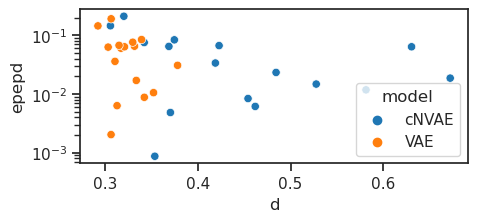

In [6]:
fig, ax = create_figure(1, 1, (5, 2))
_df1 = df_dci.loc[
    (df_dci['category'] == 'fixate1') &
    (df_dci['beta'] != 'ae')
]
sns.scatterplot(
    data=_df1,
    y='epepd',
    x='d',
    hue='model',
    ax=ax,
)
ax.set_yscale('log')

In [7]:
_df1 = df_dci.loc[
    (df_dci['category'] == 'fixate1') &
    (df_dci['model'] == 'cNVAE') &
    (df_dci['beta'] != 'ae')
]

In [8]:
sp_stats.linregress(_df1['epepd'], _df1['i'])

LinregressResult(slope=-3.509708888366657, intercept=0.8147292378630605, rvalue=-0.9117112386579744, pvalue=8.855173092613849e-07, stderr=0.42268187758565506, intercept_stderr=0.03220091128663793)

In [16]:
sp_stats.linregress(_df1['epepd'], _df1['d'])

LinregressResult(slope=-0.9265798819499973, intercept=0.49122087378201207, rvalue=-0.4814875089068858, pvalue=0.058978754508755865, stderr=0.45077770944958045, intercept_stderr=0.034341318617423525)

In [17]:
sp_stats.linregress(_df1['epepd'], _df1['c'])

LinregressResult(slope=-0.8609464432217797, intercept=0.6763173533207186, rvalue=-0.6351173159446272, pvalue=0.008205424162820307, stderr=0.2798396510601218, intercept_stderr=0.021318850549594783)

LinregressResult(slope=-0.8609464432217797, intercept=0.6763173533207186, rvalue=-0.6351173159446272, pvalue=0.008205424162820307, stderr=0.2798396510601218, intercept_stderr=0.021318850549594783)

In [18]:
sp_stats.pearsonr(_df1['epepd'], _df1['i'])

(-0.9117112386579744, 8.855173092613863e-07)

In [19]:
sp_stats.pearsonr(_df1['epepd'], _df1['d'])

(-0.48148750890688574, 0.05897875450875588)

In [20]:
sp_stats.pearsonr(_df1['epepd'], _df1['c'])

(-0.6351173159446273, 0.008205424162820303)

In [21]:
sp_stats.pearsonr(_df1['epepd'], _df1['dci'])

(-0.8957552616847395, 2.7121785044152643e-06)

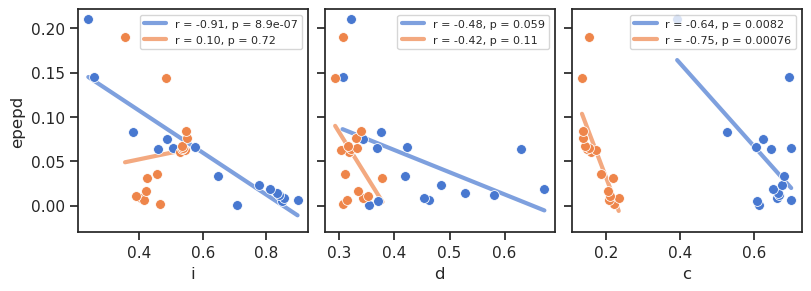

In [25]:
fig, axes = create_figure(1, 3, (8, 2.8), sharey='all', layout='constrained')

for model in ['cNVAE', 'VAE']:
    _df = df_dci.loc[
        (df_dci['category'] == 'fixate1') &
        (df_dci['model'] == model) &
        (df_dci['beta'] != 'ae')
    ]
    for i, item in enumerate(['i', 'd', 'c']):
        sns.scatterplot(
            data=_df,
            y='epepd',
            x=item,
            s=50,
            color=pal_model[model],
            ax=axes[i],
        )
        # regress
        _x = _df[item].values
        _y = _df['epepd'].values
        lr = sp_stats.linregress(_x, _y)
        x_min = _x.min()
        x_max = _x.max()
        xs = np.linspace(x_min, x_max, 1000)
        ys = lr.slope * xs + lr.intercept
        lbl = f"r = {lr.rvalue:0.2f}, p = {lr.pvalue:0.2g}"
        axes[i].plot(
            xs,
            ys,
            color=pal_model[model],
            alpha=0.7,
            ls='-',
            lw=3.0,
            zorder=0,
            label=lbl,
        )
        axes[i].set_ylim(bottom=-0.03)
        axes[i].legend(fontsize=8)
        if i > 0:
            axes[i].set_ylabel('')
plt.show()

In [26]:
_df = df_dci.loc[
    (df_dci['category'] == 'fixate1') &
    (df_dci['beta'] != 'ae')
]

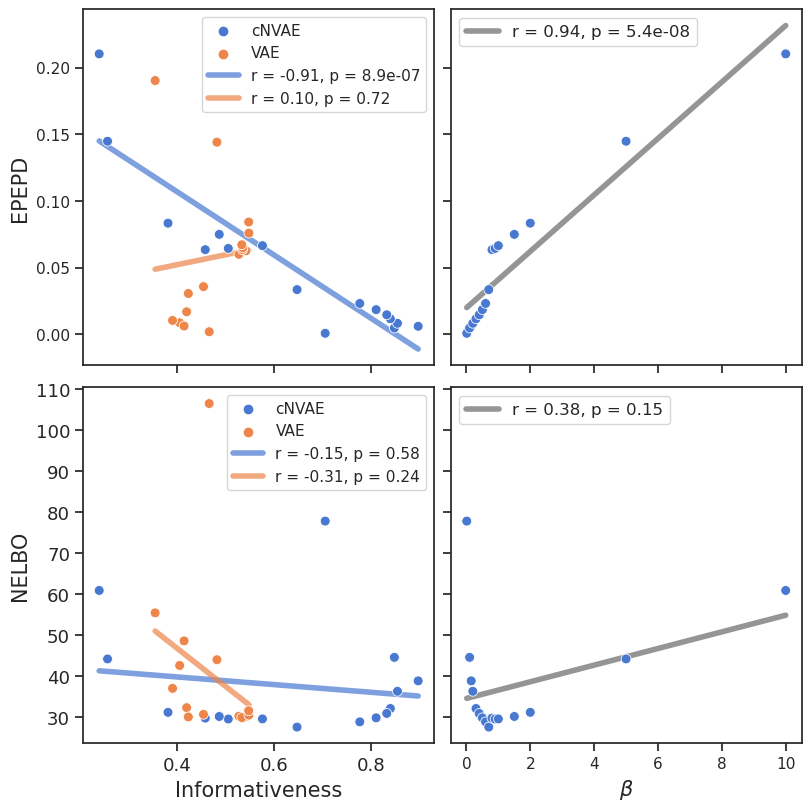

In [60]:
fig, axes = create_figure(2, 2, (8, 8), sharex='col', sharey='row', layout='constrained')
for i, loss in enumerate(['epepd', 'nelbo']):
    _df = df_dci.loc[
        (df_dci['category'] == 'fixate1') &
        (df_dci['beta'] != 'ae')
    ]
    sns.scatterplot(
        data=_df,
        y=loss,
        x='i',
        s=50,
        hue='model',
        palette=pal_model,
        ax=axes[i, 0],
    )
    sns.scatterplot(
        data=_df.loc[_df['model'] == 'cNVAE'],
        y=loss,
        x='beta',
        s=50,
        hue='model',
        palette=pal_model,
        legend=False,
        ax=axes[i, 1],
    )
    for model in ['cNVAE', 'VAE']:
        _df = df_dci.loc[
            (df_dci['category'] == 'fixate1') &
            (df_dci['model'] == model) &
            (df_dci['beta'] != 'ae')
        ]
        # regress
        _x = _df['i'].values
        _y = _df[loss].values
        lr = sp_stats.linregress(_x, _y)
        x_min = _x.min()
        x_max = _x.max()
        xs = np.linspace(x_min, x_max, 1000)
        ys = lr.slope * xs + lr.intercept
        lbl = f"r = {lr.rvalue:0.2f}, p = {lr.pvalue:0.2g}"
        axes[i, 0].plot(
            xs,
            ys,
            color=pal_model[model],
            alpha=0.7,
            ls='-',
            lw=4.0,
            zorder=0,
            label=lbl,
        )
        if model == 'cNVAE':
            _x = np.array(_df['beta'].values, dtype=float)
            _y = _df[loss].values
            lr = sp_stats.linregress(_x, _y)
            x_min = _x.min()
            x_max = _x.max()
            xs = np.linspace(x_min, x_max, 1000)
            ys = lr.slope * xs + lr.intercept
            lbl = f"r = {lr.rvalue:0.2f}, p = {lr.pvalue:0.2g}"
            axes[i, 1].plot(
                xs,
                ys,
                color='dimgrey',
                alpha=0.7,
                ls='-',
                lw=4.0,
                zorder=0,
                label=lbl,
            )
    axes[i, 1].legend(fontsize=12, loc='upper left')
    axes[i, 0].legend(fontsize=11, loc='upper right')
    axes[i, 0].set_ylabel(loss.upper(), fontsize=15)
    if i == 1:
        axes[i, 1].set_xlabel(r'$\beta$', fontsize=15)
        axes[i, 0].set_xlabel('Informativeness', fontsize=15)
        axes[i, 0].tick_params(axis='both', labelsize=13)

plt.show()

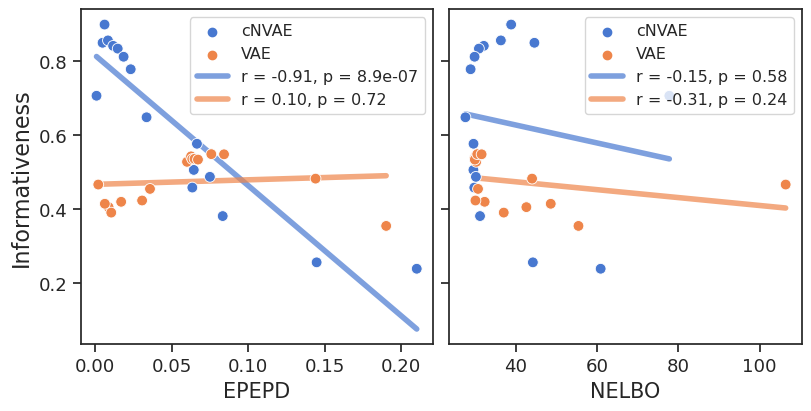

In [108]:
fig, axes = create_figure(1, 2, (8, 4), sharey='row', layout='constrained')
_df = df_dci.loc[
    (df_dci['category'] == 'fixate1') &
    (df_dci['beta'] != 'ae')
]
for i, loss in enumerate(['epepd', 'nelbo']):
    axes[i].set_xlabel(loss.upper(), fontsize=15)
    sns.scatterplot(
        data=_df,
        x=loss,
        y='i',
        s=60,
        hue='model',
        palette=pal_model,
        ax=axes[i],
    )
    for model in ['cNVAE', 'VAE']:
        _df1 = _df.loc[_df['model'] == model]
        # regress
        _x = _df1[loss].values
        _y = _df1['i'].values
        x_min = _x.min()
        x_max = _x.max()
        xs = np.linspace(x_min, x_max, 1000)
        lr = sp_stats.linregress(_x, _y)
        ys = lr.slope * xs + lr.intercept
        lbl = f"r = {lr.rvalue:0.2f}, p = {lr.pvalue:0.2g}"
        axes[i].plot(
            xs,
            ys,
            color=pal_model[model],
            alpha=0.7,
            ls='-',
            lw=4.0,
            zorder=0,
            label=lbl,
        )
    axes[i].legend(fontsize=11.5, loc='best')
    axes[i].tick_params(axis='both', labelsize=13)

# axes[1].set_xlabel(r'$\beta$', fontsize=15)
axes[0].set_ylabel('Informativeness', fontsize=16)

plt.show()

In [109]:
fig.savefig(pjoin(fig_base_dir, 'losses_vs_informativeness.pdf'), **kws_fig)

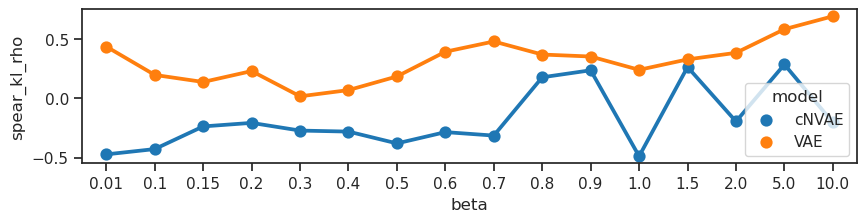

In [110]:
fig, ax = create_figure(1, 1, (10, 2))
_df1 = df_dci.loc[
    (df_dci['category'] == 'fixate1') &
    (df_dci['beta'] != 'ae')
]
sns.pointplot(data=_df1, x='beta', y='spear_kl_rho', hue='model');

In [111]:
_df = df_dci.loc[df_dci['category'] == 'fixate1']
_df.iloc[[_df['dci'].argmax()]]

,model,category,beta,nf,epe,epepd,nelbo,kl,tot_active,i,d,c,dci,rho_ent,spear_kl_rho
15,cNVAE,fixate1,0.5,420,5.370134,0.018582,29.862501,24.492367,36.0,0.811089,0.672083,0.651275,0.711483,0.295805,-0.379627


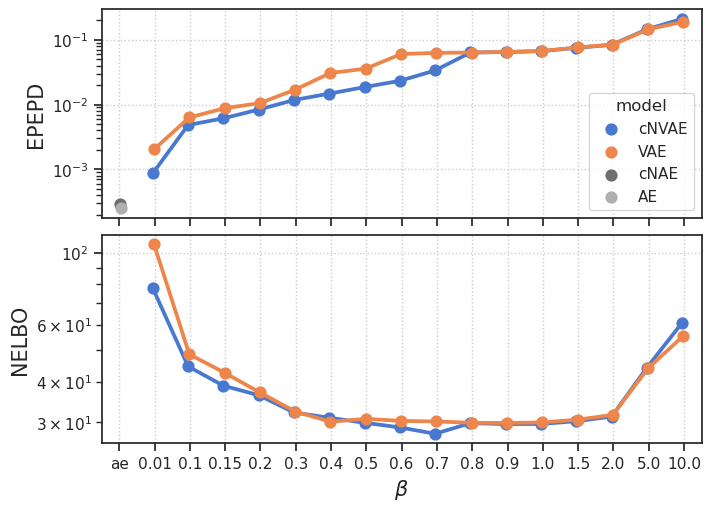

In [117]:
fig, axes = create_figure(2, 1, (7, 5), 'all', layout='constrained')
for i, loss in enumerate(['epepd', 'nelbo']):
    sns.pointplot(
        data=_df,
        y=loss,
        x='beta',
        hue='model',
        hue_order=pal_model,
        palette=pal_model,
        order=betas,
        dodge=True,
        ax=axes[i],
    )
    axes[i].set_ylabel(loss.upper(), fontsize=15)
axes[1].set_xlabel(r'$\beta$', fontsize=15)
sns.move_legend(axes[0], 'lower right')
axes[1].get_legend().remove()
axes[0].set_xlabel('')
for ax in axes.flat:
    ax.set_yscale('log')
    ax.grid()
plt.show()

In [118]:
fig.savefig(pjoin(fig_base_dir, 'losses_vs_beta.pdf'), **kws_fig)